This project uses the NYPD Complaint Data Current (Year To Date) data set from data.gov.
In this project I will try to explain trends and generate insight. I will try to answer this question "Is there a relationship between victims and suspects?"

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import date, time

In [2]:
# Read the csv file into a dataframe.
csv = 'NYPD_Complaint_Data_Current__Year_To_Date_.csv'
df = pd.read_csv(csv, low_memory=False)

print(df.columns)

Index(['CMPLNT_NUM', 'ADDR_PCT_CD', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM',
       'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT',
       'HOUSING_PSA', 'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD',
       'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PARKS_NM', 'PATROL_BORO', 'PD_CD',
       'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'STATION_NAME', 'SUSP_AGE_GROUP',
       'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_AGE_GROUP',
       'VIC_RACE', 'VIC_SEX', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude',
       'Longitude', 'Lat_Lon', 'New Georeferenced Column'],
      dtype='object')


Some of these columns are unnecessary for the analysis so they will be dropped. The columns that will remain are these:

1. Information about the crime:
    - BORO_NM: Borough
    - CMPLNT_FR_DT: date of incident
    - CMPLNT_FR_TM: time of incident
    - LAW_CAT_CD: legal classification (FELONY, MISDEMEANOR, or VIOLATION)
    - OFNS_DESC: description of the offense (ROBBERY)
2. Information about the suspect:
    - SUSP_AGE_GROUP: suspect's age group
    - SUSP_RACE: suspect's race
    - SUSP_SEX: suspect's sex
3. Information about the victim:
    - VIC_AGE_GROUP: victim's age group
    - VIC_RACE: victim's race
    - VIC_SEX: victim's sex

Also some rows must be dropped because of their values are invalid.

In [3]:
# Drop duplicate values.
df = df.drop_duplicates()

# Drop unneccessary columns.
df = df.drop(columns=[
    'CMPLNT_NUM','ADDR_PCT_CD','CMPLNT_TO_DT','CMPLNT_TO_TM','CRM_ATPT_CPTD_CD','HADEVELOPT','HOUSING_PSA',
    'JURISDICTION_CODE','JURIS_DESC', 'KY_CD','LOC_OF_OCCUR_DESC','PARKS_NM','PATROL_BORO','PD_CD',
    'PD_DESC','PREM_TYP_DESC','RPT_DT','STATION_NAME','TRANSIT_DISTRICT','X_COORD_CD','Y_COORD_CD','Latitude',
    'Longitude','Lat_Lon','New Georeferenced Column'])

# Clean the dataframe.
print('Borough', df['BORO_NM'].unique())
print('Law category', df['LAW_CAT_CD'].unique())
print('Offense description', df['OFNS_DESC'].unique())
print('Suspect age', df['SUSP_AGE_GROUP'].unique())
print('Suspect race', df['SUSP_RACE'].unique())
print('Suspect sex', df['SUSP_SEX'].unique())
print('Victim age', df['VIC_AGE_GROUP'].unique())
print('Victim race', df['VIC_RACE'].unique())
print('Victim sex', df['VIC_SEX'].unique())

# Drop rows with corrupted data.
df = df[df['BORO_NM'].isin(['BRONX', 'STATEN ISLAND', 'MANHATTAN', 'BROOKLYN', 'QUEENS'])]
df = df[df['VIC_SEX'].isin(['M', 'F', 'U'])]
df = df[df['SUSP_SEX'].isin(['M', 'F', 'U'])]
df = df[df['VIC_AGE_GROUP'].isin(['25-44', '<18', '45-64', '18-24', '65+', 'UNKNOWN'])]
df = df[df['SUSP_AGE_GROUP'].isin(['25-44', '<18', '45-64', '18-24', '65+', 'UNKNOWN'])]

# Change (null) values to unknown.
df.replace('(null)', 'UNKNOWN', inplace=True)

# Change the data types of each column.
df['BORO_NM'] = df['BORO_NM'].astype('category')
df['CMPLNT_FR_DT'] = pd.to_datetime(df['CMPLNT_FR_DT'], errors='coerce').dt.date
#######df['CMPLNT_FR_TM'] = pd.to_datetime(df['CMPLNT_FR_TM'], format='%H:%M:%S', errors='coerce').dt.time
df['CMPLNT_FR_TM'] = pd.to_datetime(df['CMPLNT_FR_TM'], format='%H:%M:%S', errors='coerce')



df['LAW_CAT_CD'] = df['LAW_CAT_CD'].astype('category')
df['OFNS_DESC'] = df['OFNS_DESC'].astype('category')
df['SUSP_AGE_GROUP'] = df['SUSP_AGE_GROUP'].astype('category')
df['SUSP_RACE'] = df['SUSP_RACE'].astype('category')
df['SUSP_SEX'] = df['SUSP_SEX'].astype('category')
df['VIC_AGE_GROUP'] = df['VIC_AGE_GROUP'].astype('category')
df['VIC_RACE'] = df['VIC_RACE'].astype('category')
df['VIC_SEX'] = df['VIC_SEX'].astype('category')

# Drop rows with complaints not from 2025.
df = df[(df['CMPLNT_FR_DT'] >= pd.to_datetime('2025-01-01').date()) & 
        (df['CMPLNT_FR_DT'] <= pd.to_datetime('2025-10-01').date())]

Borough ['BRONX' 'STATEN ISLAND' 'MANHATTAN' 'BROOKLYN' '(null)' 'QUEENS']
Law category ['FELONY' 'MISDEMEANOR' 'VIOLATION']
Offense description ['ROBBERY' 'FELONY ASSAULT' 'VEHICLE AND TRAFFIC LAWS'
 'ASSAULT 3 & RELATED OFFENSES' 'THEFT-FRAUD' 'GRAND LARCENY'
 'DANGEROUS WEAPONS' 'CRIMINAL MISCHIEF & RELATED OF'
 'MISCELLANEOUS PENAL LAW' 'HARRASSMENT 2' 'PETIT LARCENY'
 'OTHER OFFENSES RELATED TO THEFT' 'ADMINISTRATIVE CODE' 'DANGEROUS DRUGS'
 'CRIMINAL TRESPASS' 'UNAUTHORIZED USE OF A VEHICLE' 'RAPE'
 'GRAND LARCENY OF MOTOR VEHICLE' 'FORGERY'
 'OFF. AGNST PUB ORD SENSBLTY &' 'GAMBLING'
 'INTOXICATED & IMPAIRED DRIVING' 'OFFENSES AGAINST PUBLIC ADMINI'
 'OTHER STATE LAWS' 'SEX CRIMES' 'OTHER STATE LAWS (NON PENAL LAW)'
 'CANNABIS RELATED OFFENSES' 'BURGLARY' "BURGLAR'S TOOLS"
 'POSSESSION OF STOLEN PROPERTY' 'OFFENSES INVOLVING FRAUD' 'FRAUDS'
 'OFFENSES AGAINST PUBLIC SAFETY' 'OFFENSES AGAINST THE PERSON'
 'FRAUDULENT ACCOSTING' 'PETIT LARCENY OF MOTOR VEHICLE' 'ARSON'
 'CHILD ABA

For all three legal classifications, crime is the lowest in February and steadily increases until May. The next part will examine misdemeanors more closely.

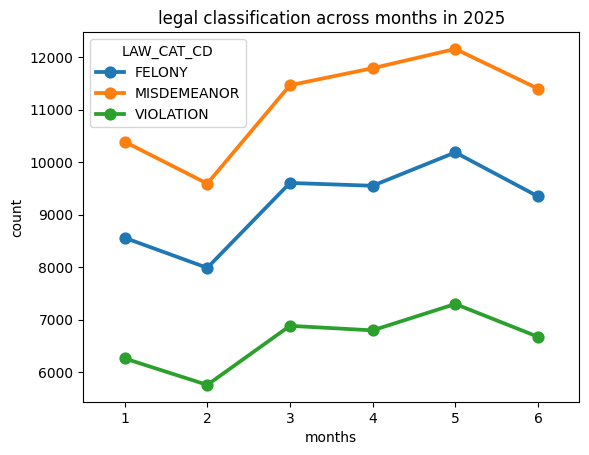

In [4]:
# Create a new column for quarters in 2025.
df['CMPLNT_FR_DT'] = pd.to_datetime(df['CMPLNT_FR_DT'], errors='coerce')
df['MONTHS'] = df['CMPLNT_FR_DT'].dt.month
df_months = df[df['MONTHS'] <= 9]

# Group by months and legal classification.
group_m_classification = df_months.groupby(['MONTHS', 'LAW_CAT_CD'], observed = False)
# Total number for each month and legal classification.
df_m_classification = group_m_classification['MONTHS'].count().reset_index(name='count')
# Sort the dataframe.
df_m_classification.sort_values(by=['MONTHS', 'LAW_CAT_CD'], ascending=False, inplace=True)

# Plot multiple columns as bar plots
sns.pointplot(x='MONTHS', y='count', hue='LAW_CAT_CD', data=df_m_classification)
# Add labels and title
plt.xlabel('months')
plt.ylabel('count')
plt.title('legal classification across months in 2025')
# Show the plot
plt.show()

After making a graph of the legal classification across each borough for the year 2025, it is clear that misdemeanor's are the highest across each borough. Also, crime is the lowest in Staten Island.

0


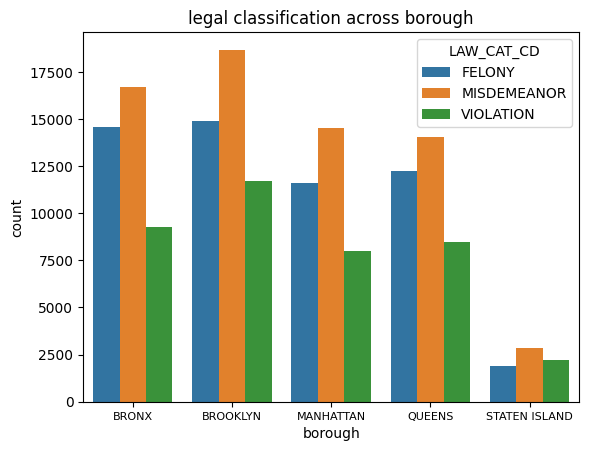

In [5]:
# Group by borough and legal classification.
group_classification = df.groupby(['BORO_NM', 'LAW_CAT_CD'], observed = False)
# Total number for each brorough and legal classification.
df_classification = group_classification['BORO_NM'].count().reset_index(name='count')
# Sort the dataframe.
df_classification.sort_values(by=['BORO_NM', 'LAW_CAT_CD'], ascending=False, inplace=True)

print(df_classification[df_classification['BORO_NM']=='UNKNOWN']['count'].sum())

# Plot multiple columns as bar graph
sns.barplot(x = 'BORO_NM', y = 'count', hue='LAW_CAT_CD', data = df_classification)
# change size of x tics label
plt.xticks(fontsize = 8)
# Add labels and title
plt.xlabel('borough')
plt.ylabel('count')
plt.title('legal classification across borough')
# Show the plot
plt.show()

Assault in the 3rd degree is the top misdemeanor for each borough. Next examine the ages of victims of this crime.

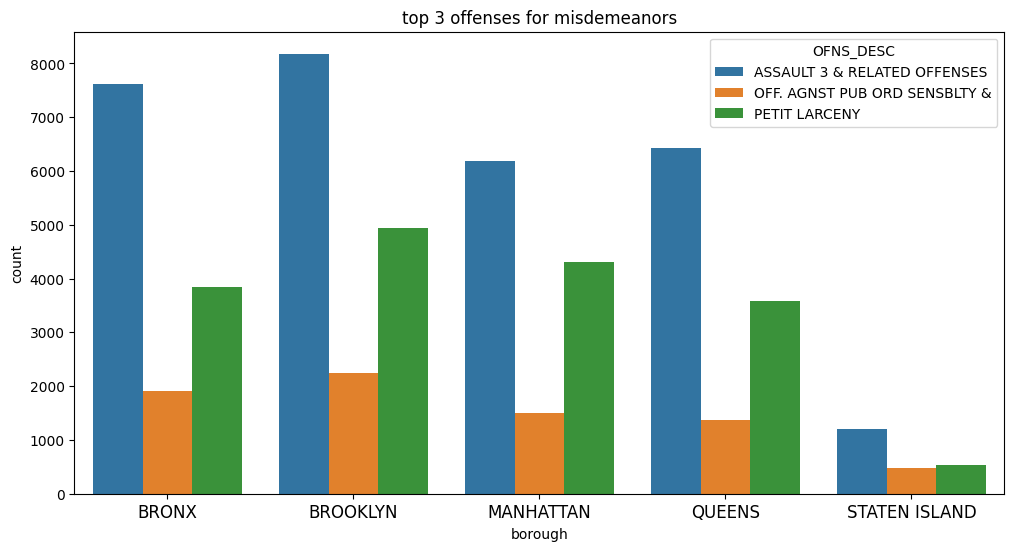

In [6]:
# Examine only misdemeanors.
df2 = df[df['LAW_CAT_CD'] == 'MISDEMEANOR']

# Group by borough and offense description.
group_offense = df2.groupby(['BORO_NM', 'OFNS_DESC'], observed = False)
# Total number for each borough and offense description.
df_offense = group_offense['BORO_NM'].count().reset_index(name='count')

# Sort the dataframe.
df_offense.sort_values(by=['BORO_NM', 'count'], ascending = False, inplace=True)

# Show only the top 3.
df_offense = df_offense.groupby('BORO_NM', observed = False).head(3)

# Sort so the bars are in order.
#df_offense.sort_values(by=['BORO_NM', 'OFNS_DESC'], ascending=False, inplace=True)

# Remove extra offenses for the graph's legend.
df_offense['OFNS_DESC'] = df_offense['OFNS_DESC'].cat.remove_unused_categories()

plt.figure(figsize=(12, 6))
# Plot multiple columns as bar graph
sns.barplot(x = 'BORO_NM', y = 'count', hue='OFNS_DESC', data = df_offense)
# change size of x tics label
plt.xticks(fontsize = 12)
# Add labels and title
plt.xlabel('borough')
plt.ylabel('count')
plt.title('top 3 offenses for misdemeanors')
# Show the plot
plt.show()


The age group 25-44 are victims of assault in the 3rd degree. People over the age of 65+ were the least affected age group in the first two quarters of 2025.

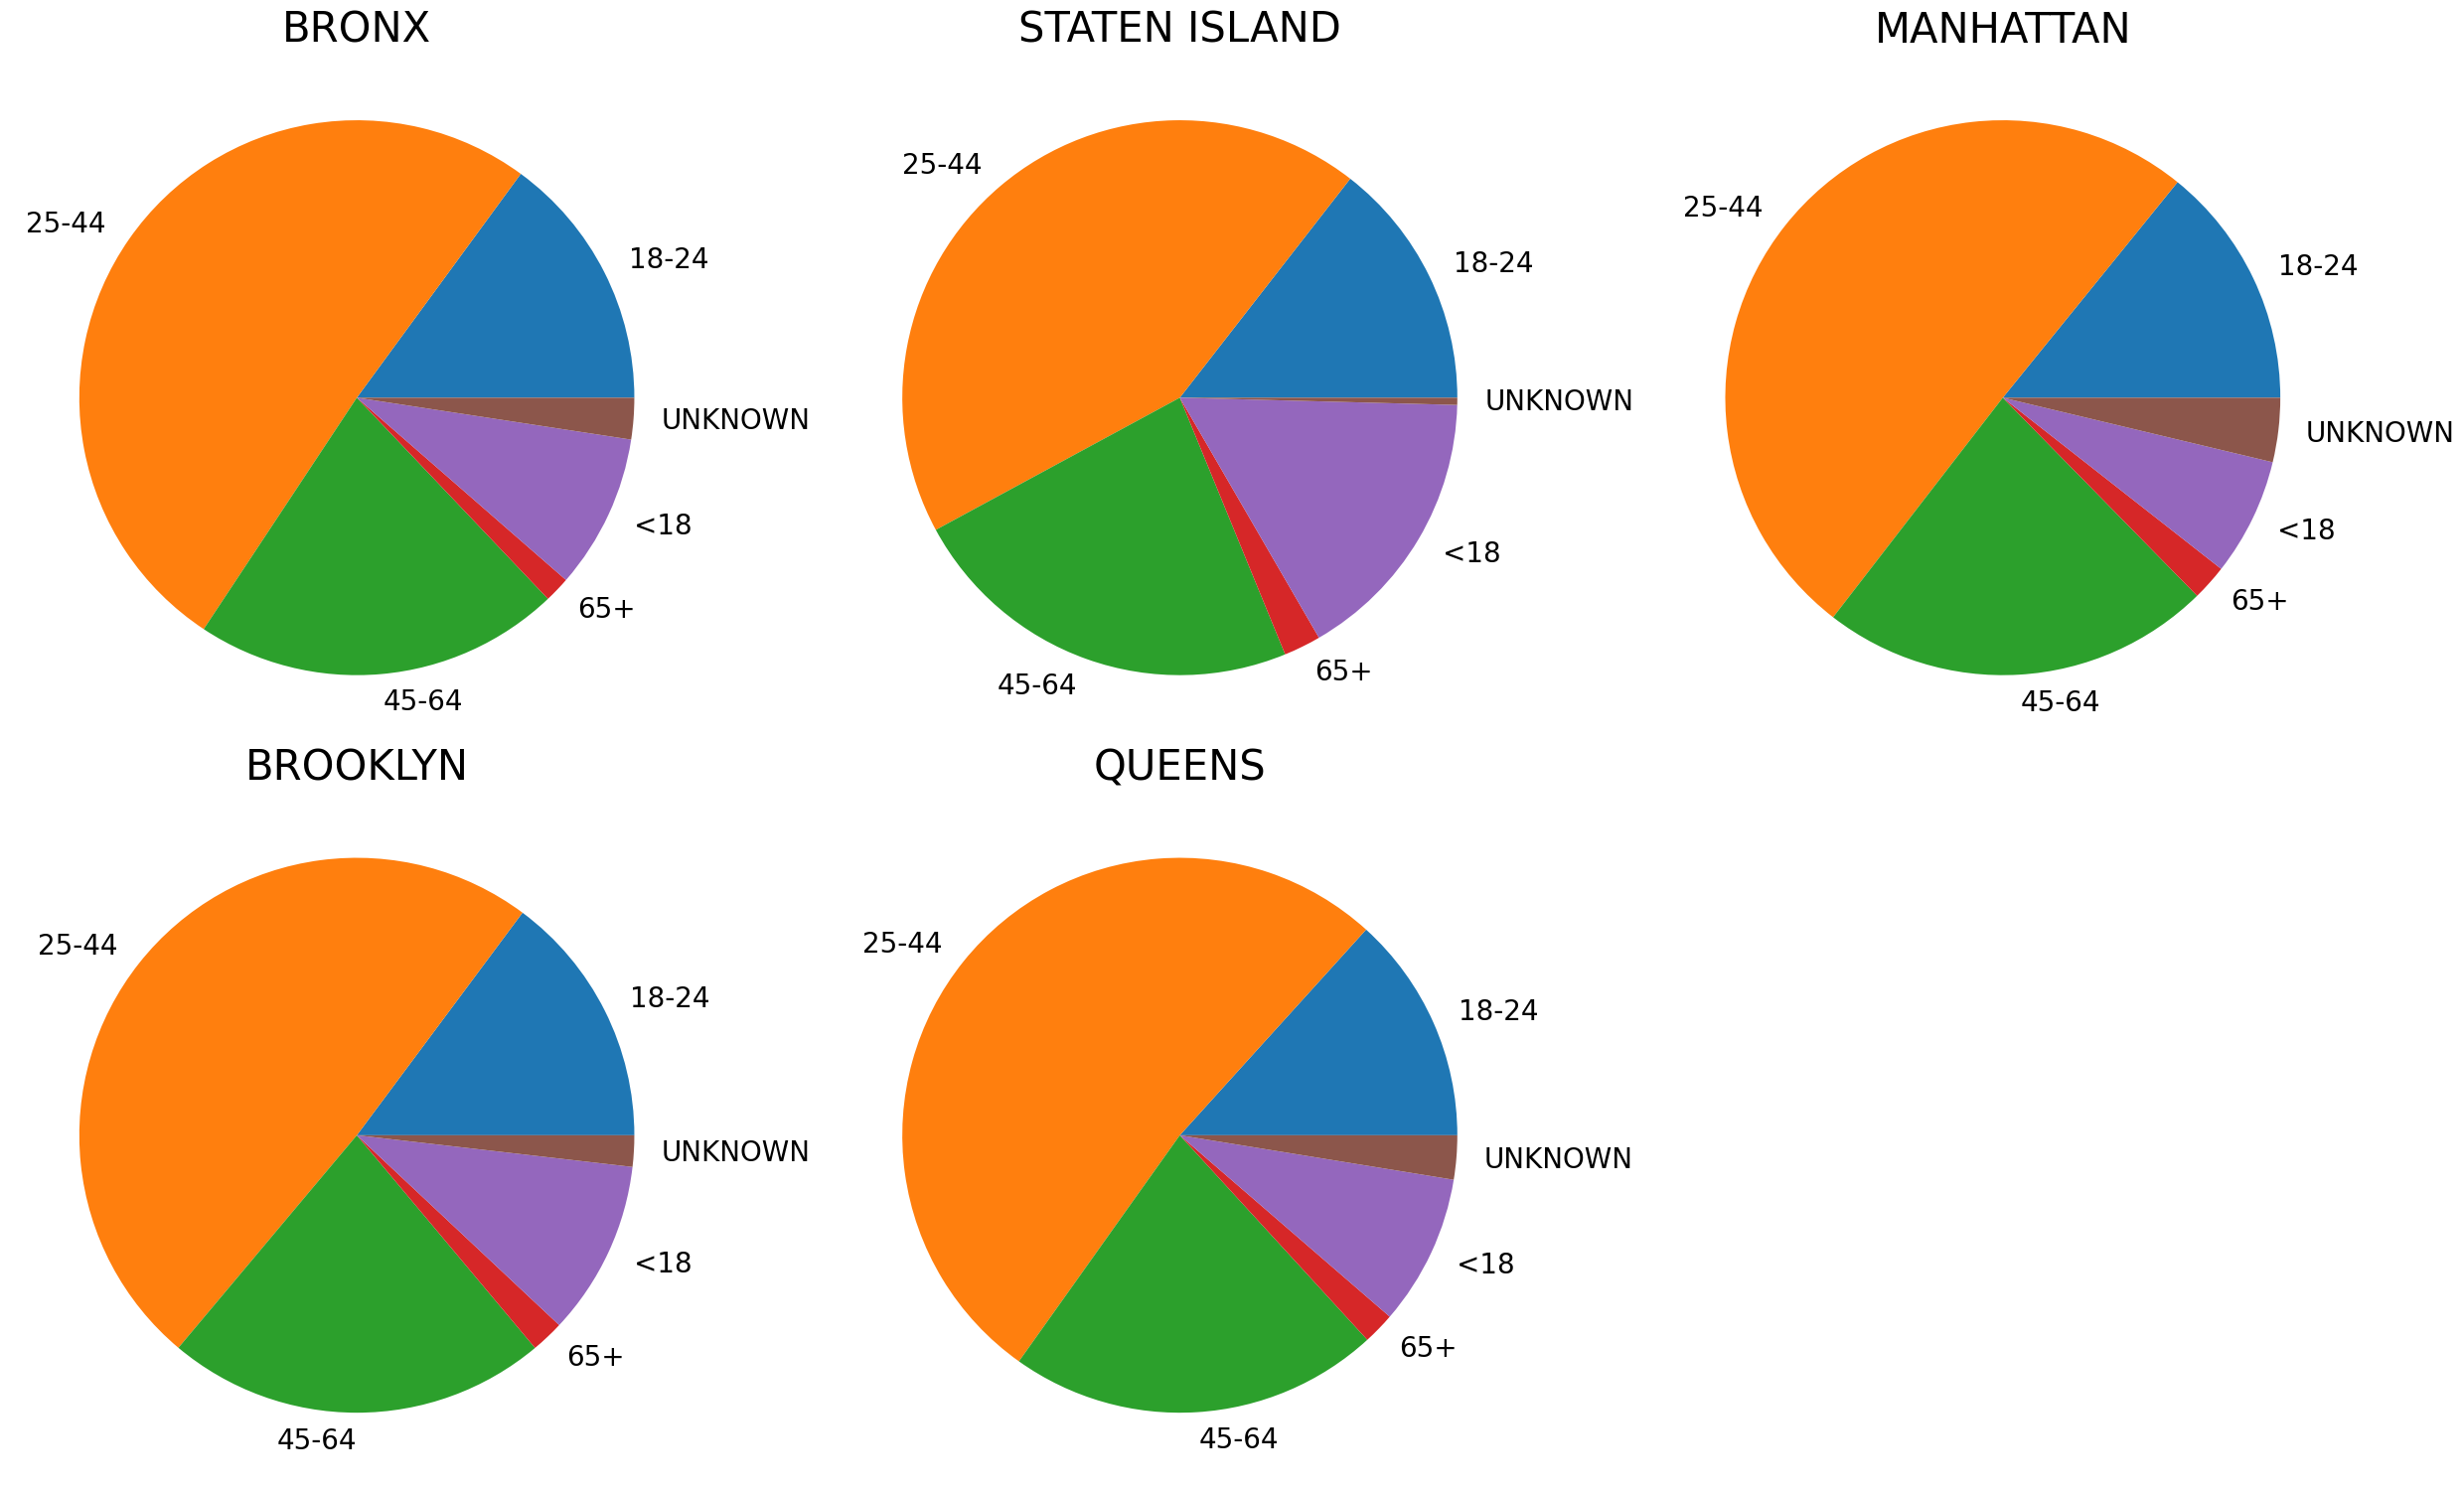

In [7]:
# Create a list for boroughs.
boroughs = ['BRONX', 'STATEN ISLAND', 'MANHATTAN', 'BROOKLYN', 'QUEENS']

# Create a figure with six subplots.
fig, axes = plt.subplots(2, 3, figsize=(25, 15))

plt.tight_layout()

# Flatten to iterate over easily.
axes = axes.flatten()

# Create charts for each borough.
for i in range(5):
    boro = boroughs[i]
    df2 = df[(df['OFNS_DESC'] == 'ASSAULT 3 & RELATED OFFENSES') & (df['BORO_NM'] == boro)]

    # Group by borough and victim's age.
    group_victim = df2.groupby('VIC_AGE_GROUP', observed = False)
    # Total number for dataframe.
    df_victim = group_victim['VIC_AGE_GROUP'].count().reset_index(name='count')

    axes[i].pie(df_victim['count'], labels=df_victim['VIC_AGE_GROUP'], textprops={'fontsize': 20})
    axes[i].set_title(f'{boro}', fontsize=30)

# Turn off sixth plot.
axes[5].axis('off')

plt.show()


There isn't an overlap between the victim's race for this particular crime like there is age. Next examine the suspect's age and race for the same crime.

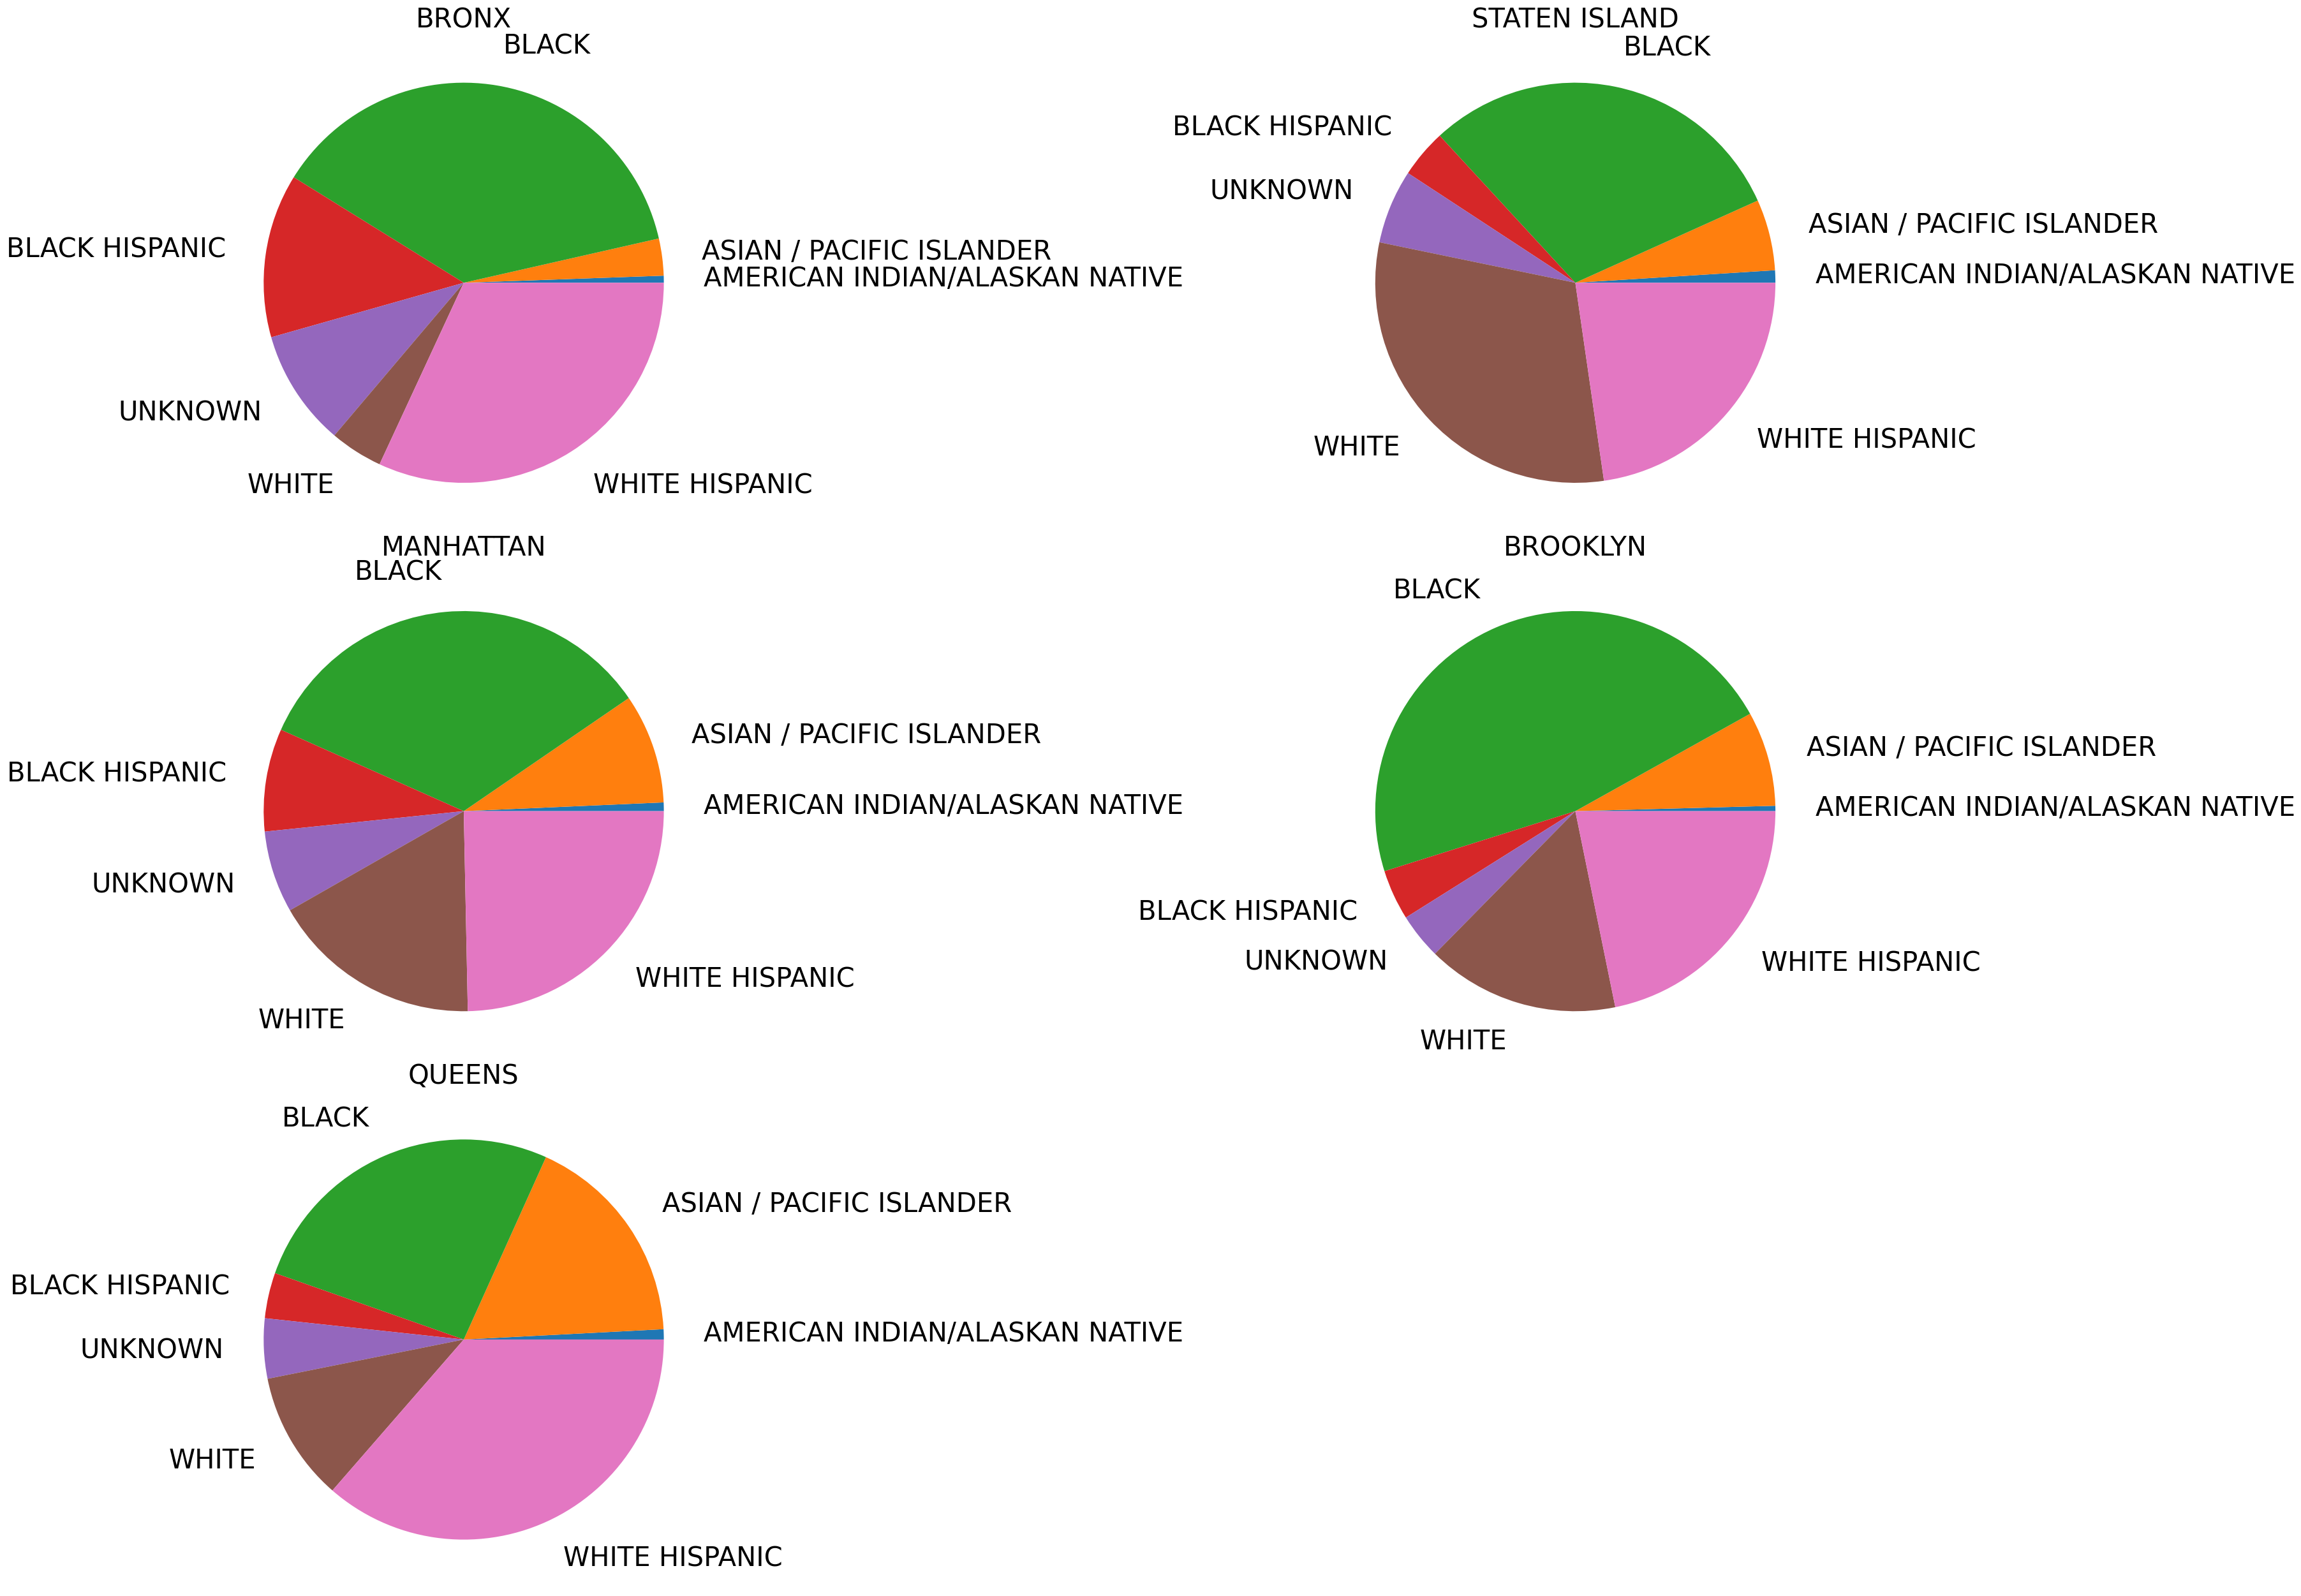

In [8]:
# Create a list for boroughs.
boroughs = ['BRONX', 'STATEN ISLAND', 'MANHATTAN', 'BROOKLYN', 'QUEENS']

# Create a figure with two subplots.
fig, axes = plt.subplots(3, 2, figsize=(35, 25))

plt.tight_layout()

# Flatten to iterate over.
axes = axes.flatten()

for i in range(5):
    boro = boroughs[i]
    df2 = df[(df['OFNS_DESC'] == 'ASSAULT 3 & RELATED OFFENSES') & (df['BORO_NM'] == boro)]

    # Group by borough and victim's race.
    group_victim = df2.groupby('VIC_RACE', observed = False)
    # Total number for dataframe.
    df_victim = group_victim['VIC_RACE'].count().reset_index(name='count')

    axes[i].pie(df_victim['count'], labels = df_victim['VIC_RACE'], labeldistance = 1.2, textprops={'fontsize': 30})
    axes[i].set_title(f'{boro}', fontsize=30)

# Turn off sixth plot.
axes[5].axis('off')

plt.show()

# White hispanic, white, black, black , white hispanic

For all of the boroughs, the suspects for assault 3 and related offenses are in the same age group as victims 25-44. However a significant portion of the suspect's ages are unknown.

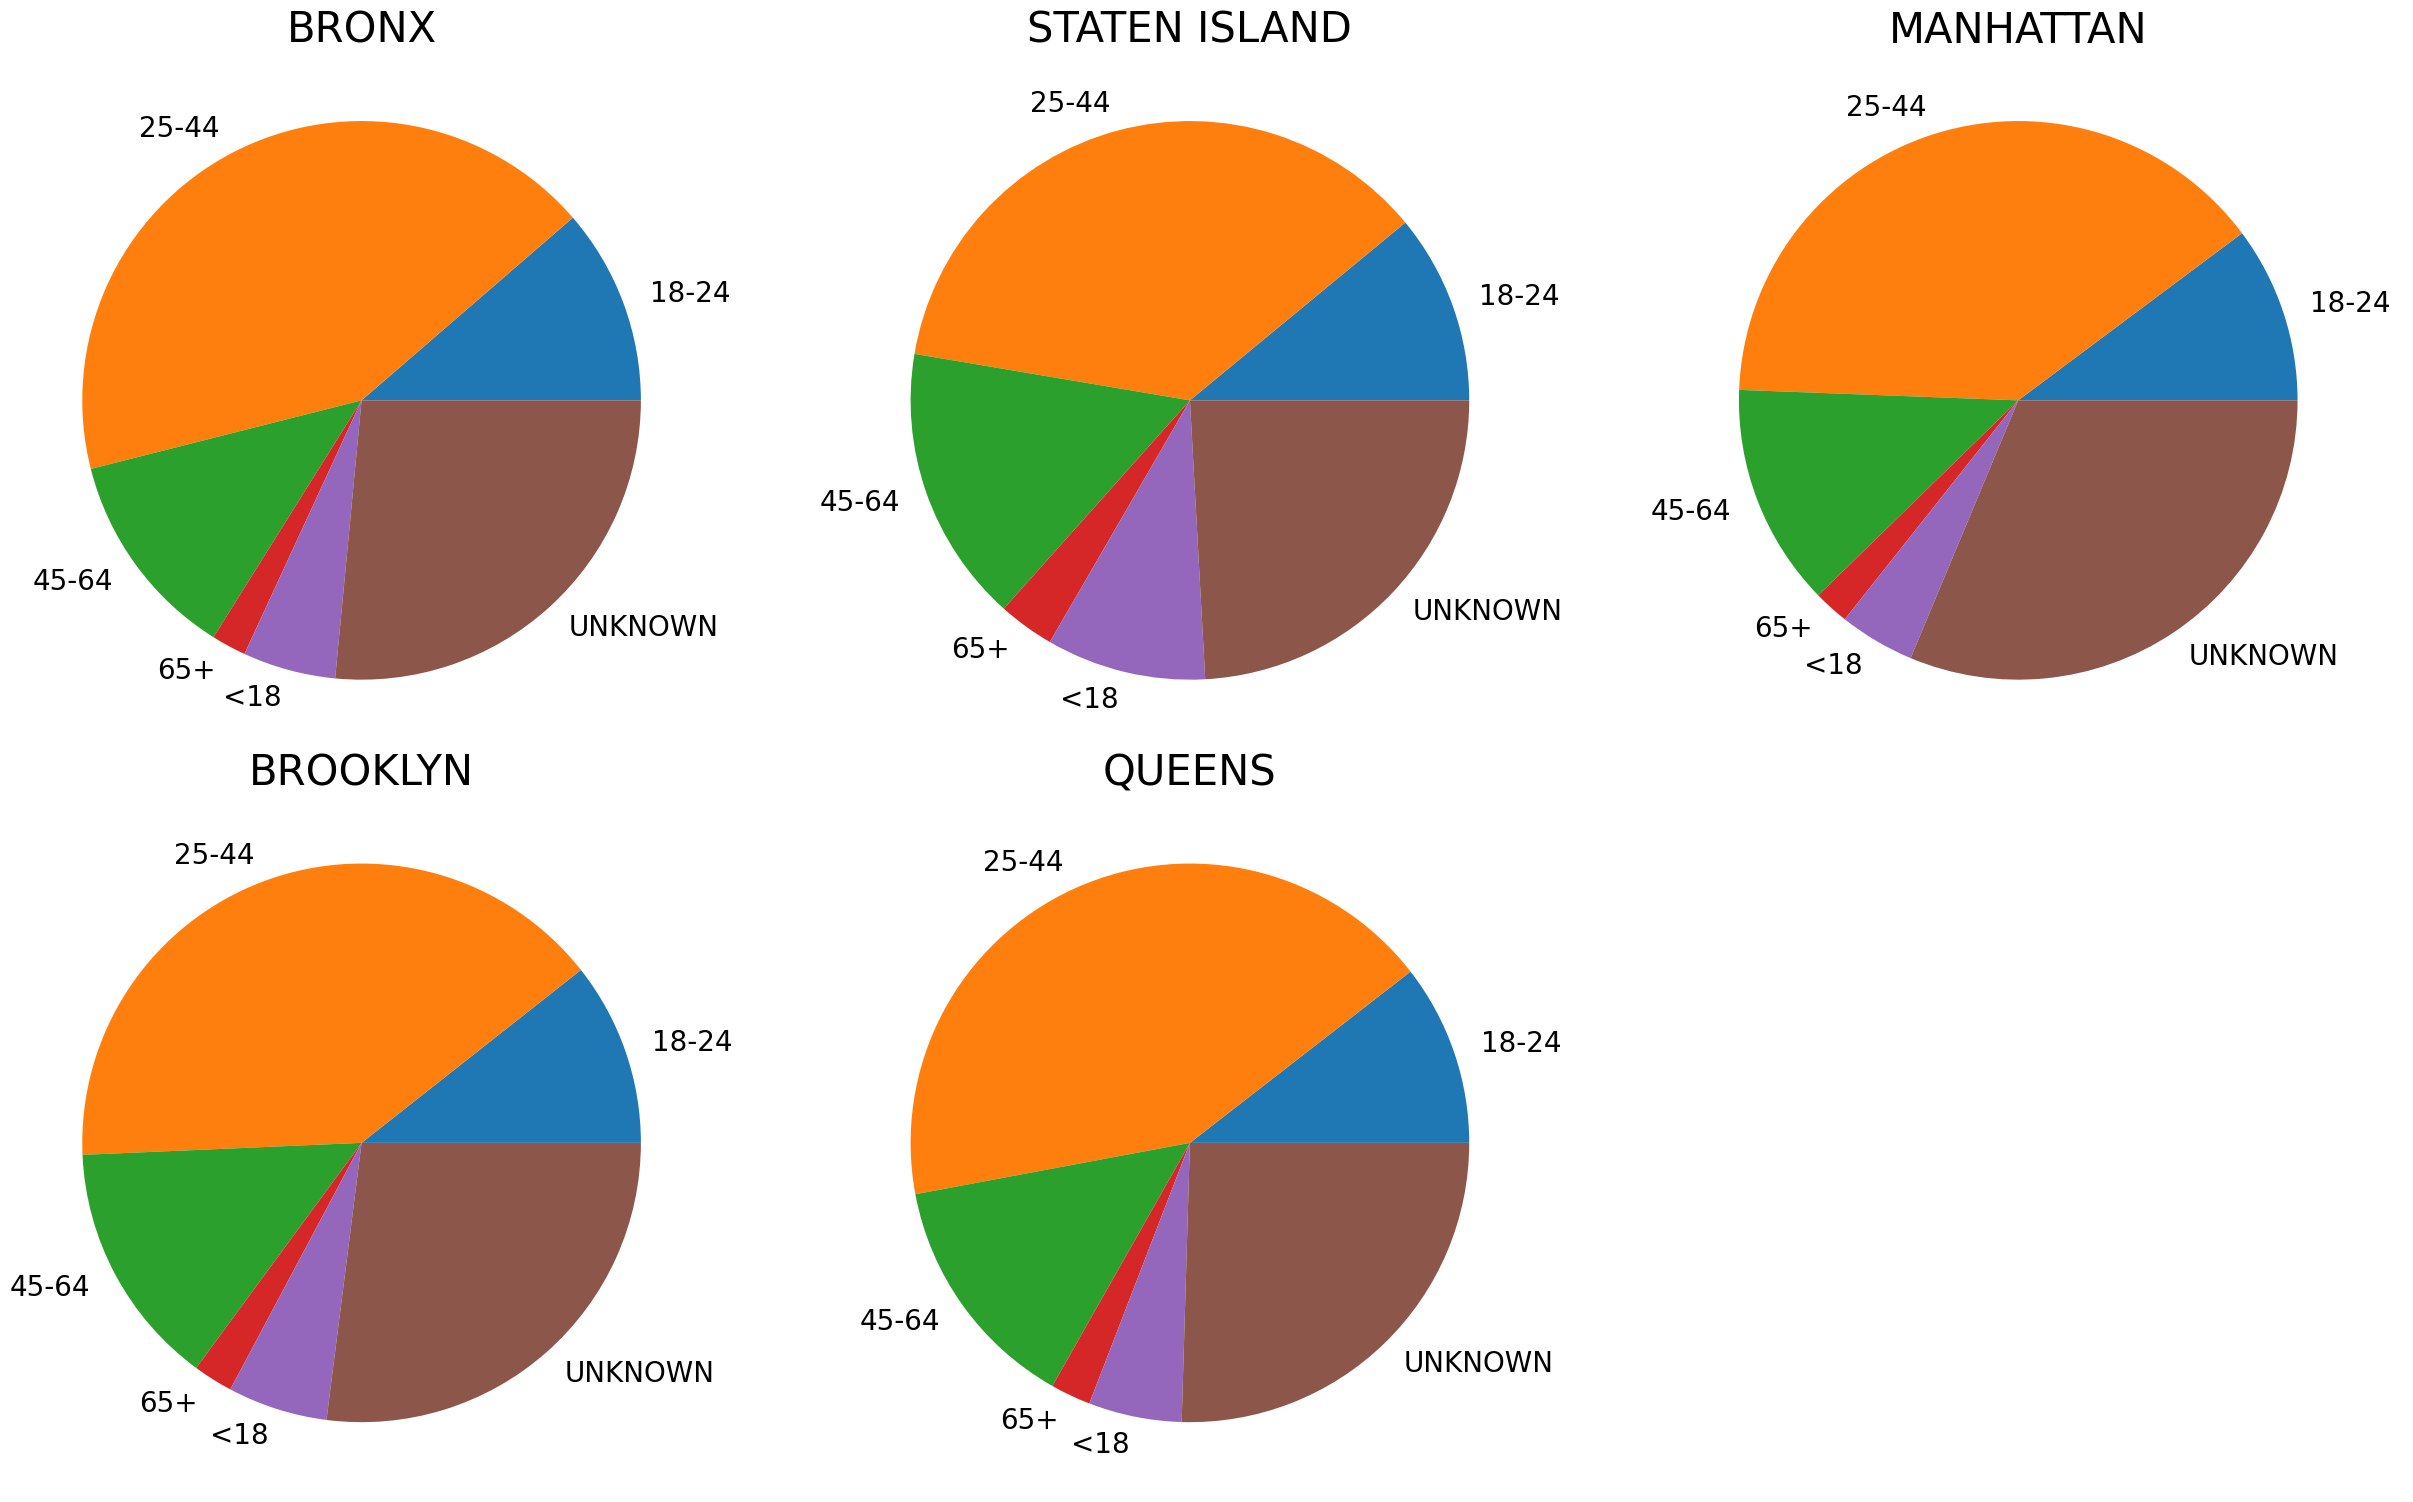

In [9]:
# Create a list for boroughs.
boroughs = ['BRONX', 'STATEN ISLAND', 'MANHATTAN', 'BROOKLYN', 'QUEENS']

# Create a figure with six subplots.
fig, axes = plt.subplots(2, 3, figsize=(25, 15))

plt.tight_layout()

# Flatten to iterate over easily.
axes = axes.flatten()

# Create charts for each borough.
for i in range(5):
    boro = boroughs[i]
    df2 = df[(df['OFNS_DESC'] == 'ASSAULT 3 & RELATED OFFENSES') & (df['BORO_NM'] == boro)]

    # Group by borough and suspect's age.
    group_sus = df2.groupby('SUSP_AGE_GROUP', observed = False)
    # Total number for dataframe.
    df_sus = group_sus['SUSP_AGE_GROUP'].count().reset_index(name='count')

    axes[i].pie(df_sus['count'], labels=df_sus['SUSP_AGE_GROUP'], textprops={'fontsize': 20})
    axes[i].set_title(f'{boro}', fontsize=30)

# Turn off sixth plot.
axes[5].axis('off')

plt.show()


The pie chart representing the race of potential suspects in each borough looks similar to the previous pice chart showing the races of victims.

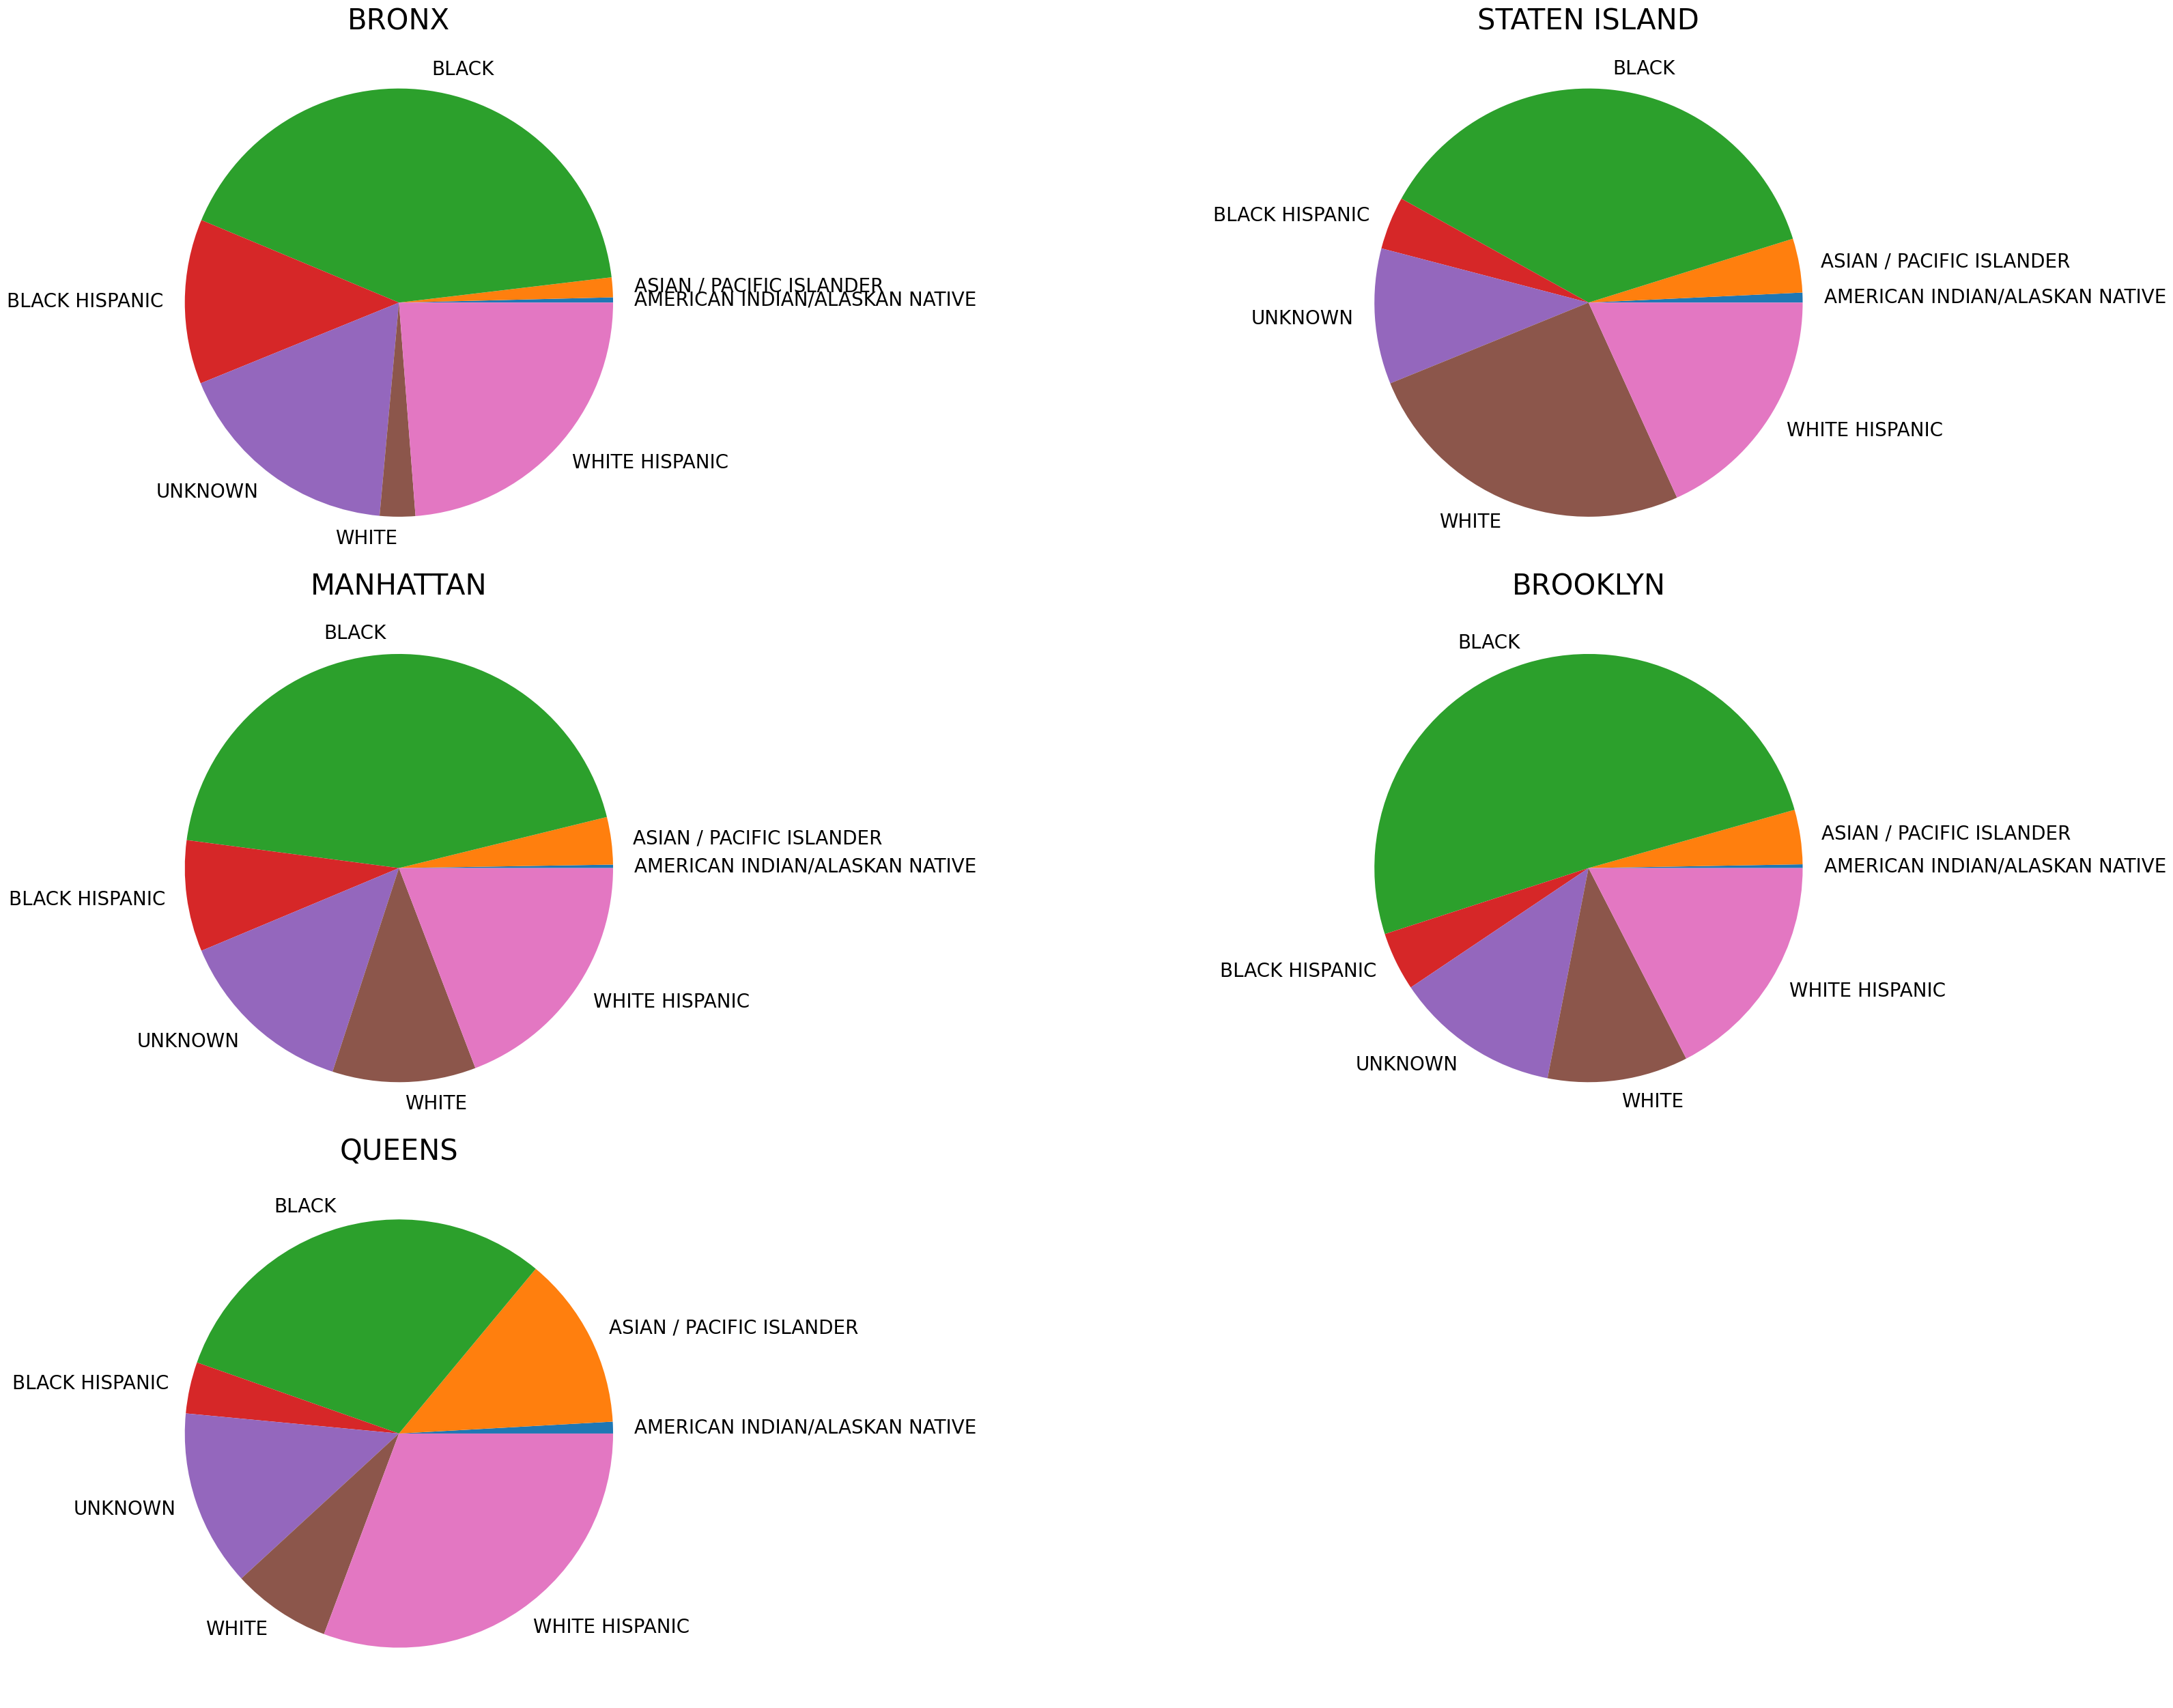

In [10]:
# Create a list for boroughs.
boroughs = ['BRONX', 'STATEN ISLAND', 'MANHATTAN', 'BROOKLYN', 'QUEENS']

# Create a figure with six subplots.
fig, axes = plt.subplots(3, 2, figsize=(35, 25))

plt.tight_layout()

# Flatten to iterate over easily.
axes = axes.flatten()

# Create charts for each borough.
for i in range(5):
    boro = boroughs[i]
    df2 = df[(df['OFNS_DESC'] == 'ASSAULT 3 & RELATED OFFENSES') & (df['BORO_NM'] == boro)]

    # Group by borough and suspect's race.
    group_sus = df2.groupby('SUSP_RACE', observed = False)
    # Total number for dataframe.
    df_sus = group_sus['SUSP_RACE'].count().reset_index(name='count')

    axes[i].pie(df_sus['count'], labels=df_sus['SUSP_RACE'], textprops={'fontsize': 20})
    axes[i].set_title(f'{boro}', fontsize=30)

# Turn off sixth plot.
axes[5].axis('off')

plt.show()


Next examine when assault 3 occurs the most often during May. First find the top 3 boroughs where assault in the 3rd degree is the most common. They are Brooklyn, Bronx, and Queens.

In [ ]:
df2 = df[df['OFNS_DESC'] == 'ASSAULT 3 & RELATED OFFENSES']
df2 = df2.groupby('BORO_NM', observed = False)['BORO_NM'].count().reset_index(name = 'count')
df2.sort_values(by=['count'], ascending=False, inplace=True)
print(df2.head(3))

    BORO_NM  count
1  BROOKLYN   8180
0     BRONX   7624
3    QUEENS   6435


According to the heatmap, assault in the 3rd degree for the month of May is the highest on Friday, Saturday, and Sunday. It is also higher from 6 pm until am.

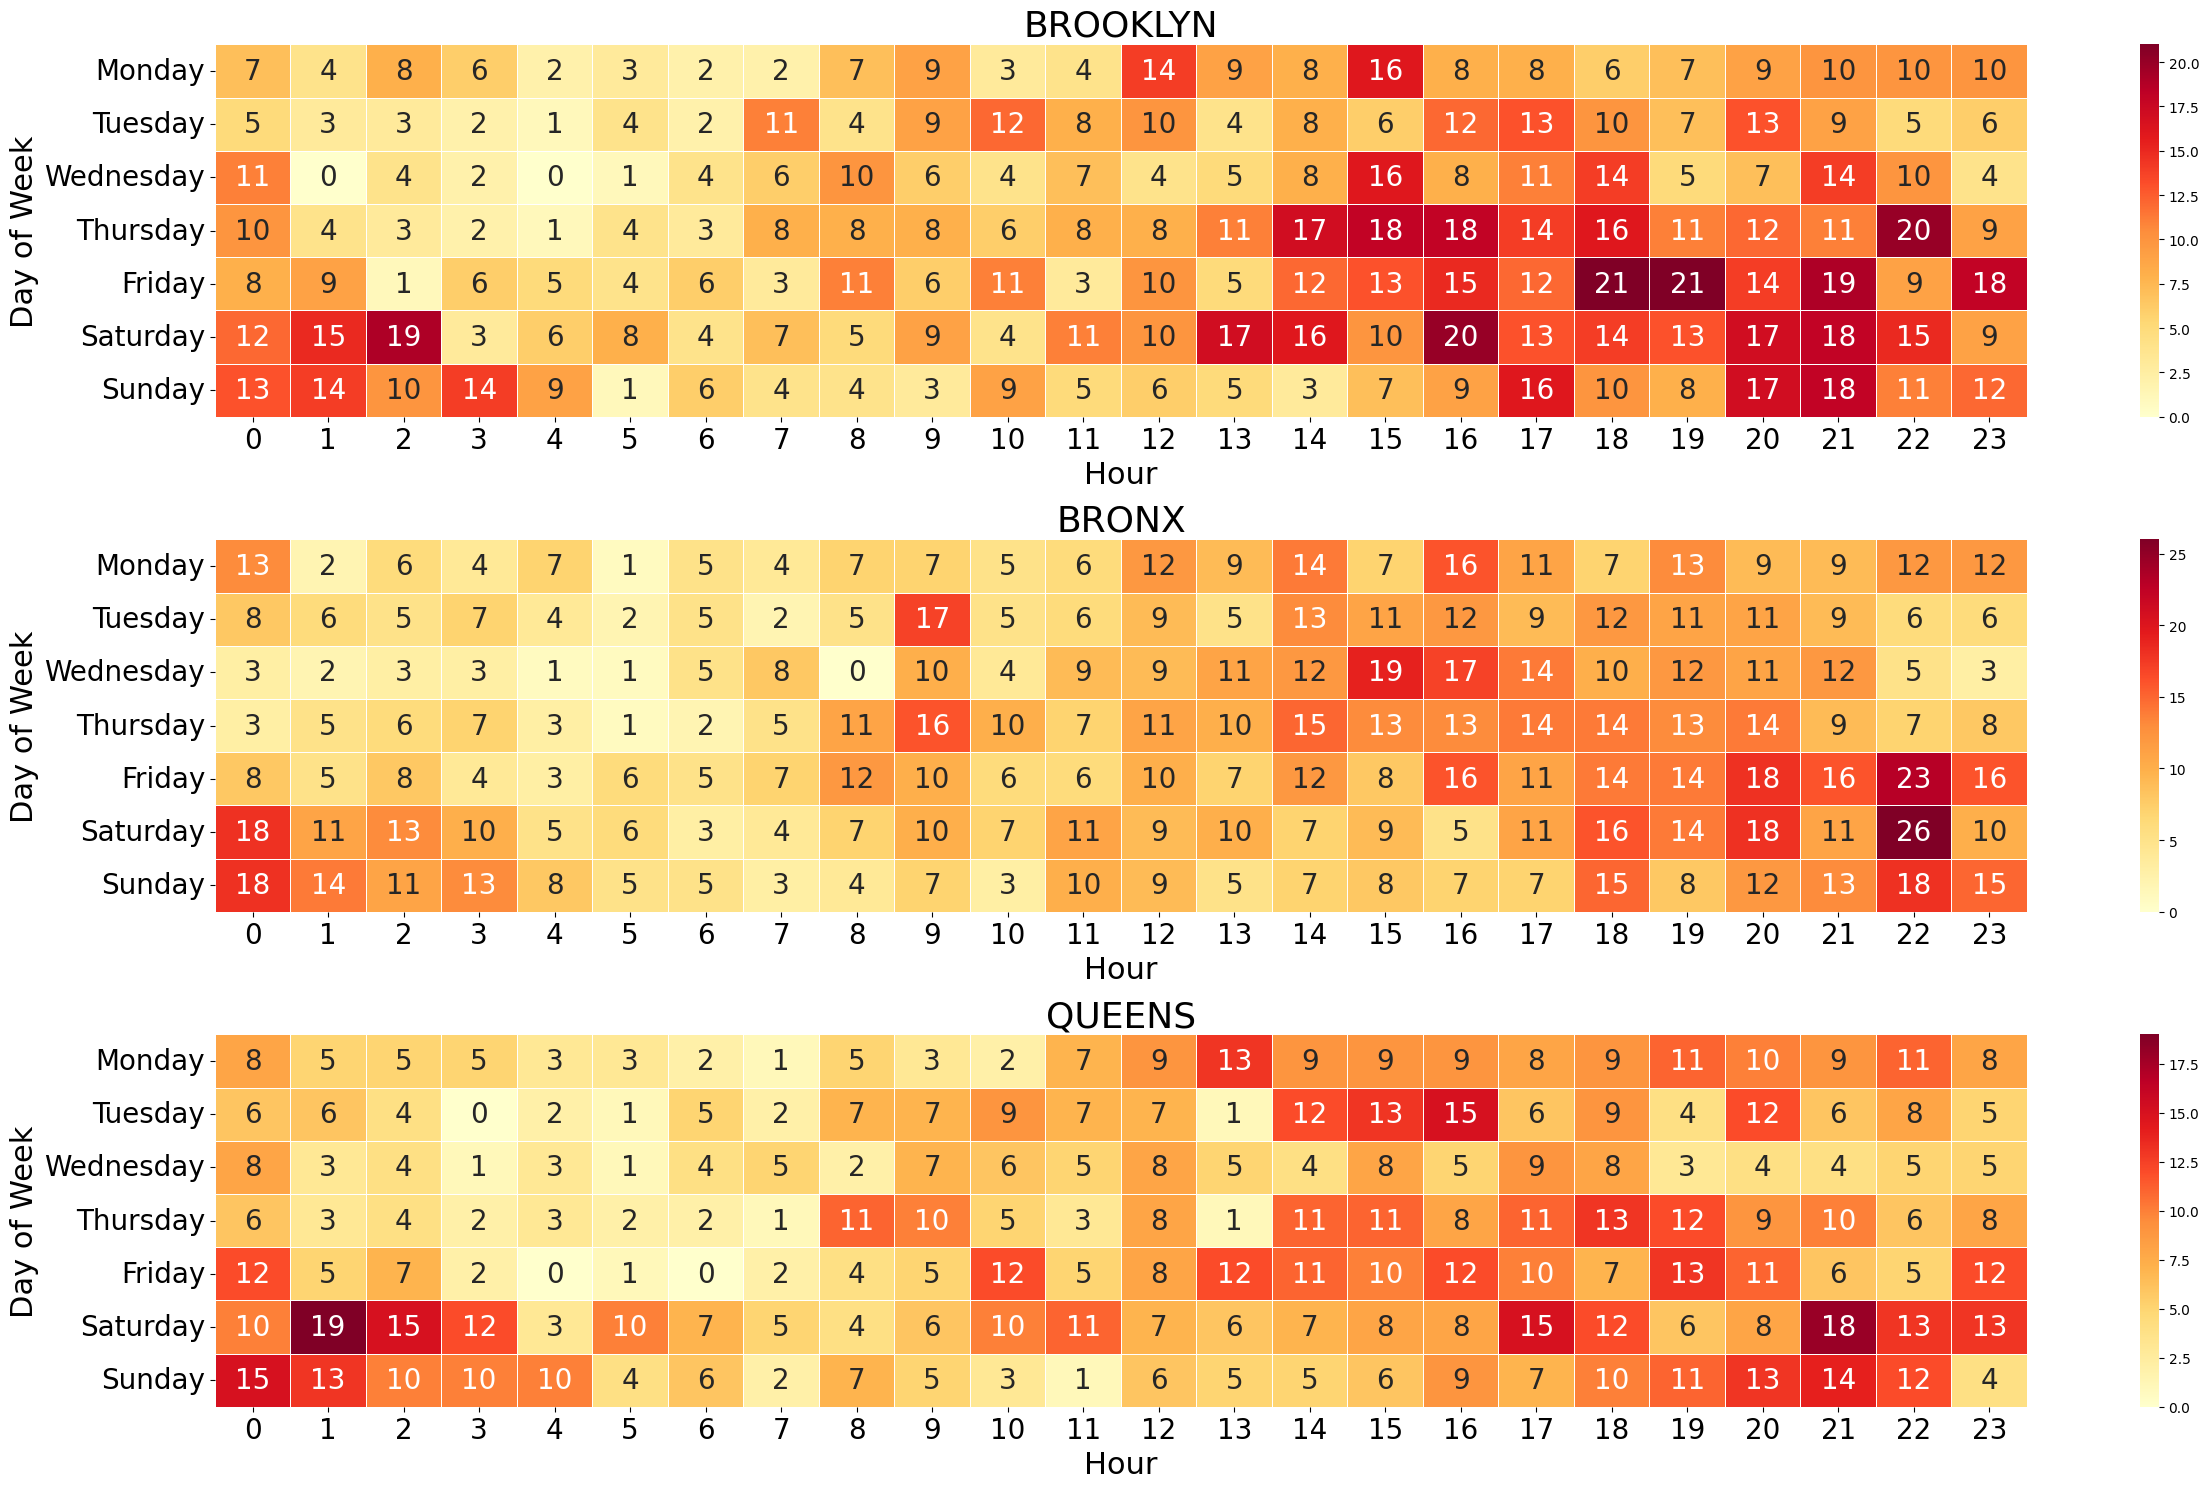

In [43]:
# Create a new column for days of the week and hour in 2025.
df['DAY_OF_WEEK'] = df['CMPLNT_FR_DT'].dt.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['DAY_OF_WEEK'] = pd.Categorical(df['DAY_OF_WEEK'], categories = day_order, ordered = True)
df['HOUR'] = df['CMPLNT_FR_TM'].dt.hour

# Create a list for boroughs.
boroughs = ['BROOKLYN', 'BRONX', 'QUEENS']

# Create a figure with six subplots.
fig, axes = plt.subplots(3, 1, figsize=(25, 15))

plt.tight_layout()

# Flatten to iterate over easily.
axes = axes.flatten()

# Create charts for each borough.
for i in range(3):
    # Examine assault in the 3rd degree for the month of May.
    boro = boroughs[i]
    df2 = df[(df['OFNS_DESC'] == 'ASSAULT 3 & RELATED OFFENSES') & (df['BORO_NM'] == boro) & (df['MONTHS'] == 5)].copy()

    # Group by day of the week and hour.
    group_time = df2.groupby(['DAY_OF_WEEK', 'HOUR'], observed = False)
    # Total number for dataframe.
    df_time = group_time['DAY_OF_WEEK'].count().reset_index(name ='count')
    # Now you can sort by it
    df_time.sort_values(by=['DAY_OF_WEEK', 'HOUR'], inplace=True)

    # Change the dataframe so index is days of week, columns are hour, and values are the count.
    heat_map_df = df_time.pivot(index = 'DAY_OF_WEEK', columns = 'HOUR', values = 'count')

    sns.heatmap(heat_map_df, ax = axes[i], cmap='YlOrRd', linewidths=0.5, annot=True, annot_kws={"size": 20})
    axes[i].set_title(f'{boro}', fontsize = 26)
    axes[i].set_xlabel('Hour', fontsize = 22)
    axes[i].set_ylabel('Day of Week', fontsize = 22)
    axes[i].tick_params(axis='both', labelsize = 20)

    plt.xlabel('Hour')
    plt.ylabel('Day of Week')
    plt.tight_layout()


plt.show()



1. Time of Day / Day of Week
When do Assault 3 incidents most often occur?
Are there spikes during weekends, late nights, or specific seasons?

2. Location Type
If you have access to incident location types (e.g., residence, street, bar, school), you can analyze where Assault 3 tends to happen.
Why it matters: It adds context — are these public altercations, domestic disputes, or workplace conflicts?

LOC_OF_OCCUR_DESC: Description of where the incident happened (e.g., inside, outside).
PREM_TYP_DESC: Type of premises (e.g., residence, store, subway station).
STATION_NAME: Transit station name if the incident occurred in the subway.
PARKS_NM: Name of the park if the incident occurred in a park.
TRANSIT_DISTRICT: Transit district code if related to subway or bus system.
